In [ ]:
!pip install git+https://github.com/thibmonsel/diffrax.git@56d8c0b1d7de9dd90c9b44d7d62dc8eef253d022

  Cloning https://github.com/thibmonsel/diffrax.git (to revision 56d8c0b1d7de9dd90c9b44d7d62dc8eef253d022) to /tmp/pip-req-build-lwi1q_tw
  Running command git clone --filter=blob:none --quiet https://github.com/thibmonsel/diffrax.git /tmp/pip-req-build-lwi1q_tw
  Running command git rev-parse -q --verify 'sha^56d8c0b1d7de9dd90c9b44d7d62dc8eef253d022'
  Running command git fetch -q https://github.com/thibmonsel/diffrax.git 56d8c0b1d7de9dd90c9b44d7d62dc8eef253d022
  Running command git checkout -q 56d8c0b1d7de9dd90c9b44d7d62dc8eef253d022
  Resolved https://github.com/thibmonsel/diffrax.git to commit 56d8c0b1d7de9dd90c9b44d7d62dc8eef253d022
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import time
import diffrax
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

$$
    \left\{\begin{array}{l}
    \frac{d T(t)}{d t}=r T(t)\left(1-\frac{T(t)}{K}\right)-n E(t) T(t),\\
    \frac{d E(t)}{d t}=\sigma+\mu T(t-\tau) E(t)-\eta E(t)
    \end{array}\right.
$$

In [ ]:
y0 = jnp.array([1.9,1.9])
r=2.5
K=2.
n=0.8
omega=0.5
miu=0.4
nu=1.5
def delay_tumor(t, y, args, *, history):
    T = y[0]
    E = y[1]
    delay_T = history[0][0]
    delay_E = history[0][1]
    x0 = r*T*(1-(T/K))-(n*T*E)
    x1 = omega+miu*delay_T*E-nu*E
    return jnp.stack([x0, x1], axis=-1)


def history_function(t):
    return y0

In [ ]:
delays = diffrax.Delays(
    delays=[lambda t, y, args: 5], initial_discontinuities=jnp.array([0.0,0.0])
)

In [ ]:
@jax.jit
def main():
    terms = diffrax.ODETerm(delay_tumor)
    t0 = 0.0
    t1 = 10.0
    ts = jnp.linspace(0, 10, 3000)
    solver = diffrax.Tsit5()
    stepsize_controller = diffrax.PIDController(rtol=1e-3, atol=1e-6)
    sol = diffrax.diffeqsolve(
        terms,
        solver,
        t0,
        t1,
        ts[1] - ts[0],
        y0=history_function,
        saveat=diffrax.SaveAt(ts=ts, dense=True),
        stepsize_controller=stepsize_controller,
        delays=delays,
    )
    return sol

Integration took in 0.0014433860778808594 seconds.


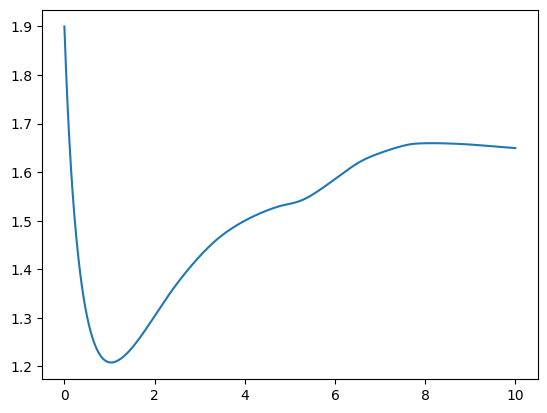

In [ ]:
main()
start = time.time()
sol = main()
end = time.time()
print(f"Integration took in {end - start} seconds.")

plt.plot(sol.ts, sol.ys[:, 0])
plt.show()

EJEMPLO NDDE

In [ ]:
import time
import diffrax
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax
import jax.nn as jnn
import jax.numpy as jnp
import jax.random as jrandom
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax

In [ ]:
delays = diffrax.Delays(
    delays=[lambda t, y, args: 0.2], initial_discontinuities=jnp.array([0.0])
)

In [ ]:
class Func(eqx.Module):
    mlp: eqx.nn.MLP

    def __init__(self, data_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.mlp = eqx.nn.MLP(
            in_size=data_size,
            out_size=data_size,
            width_size=width_size,
            depth=depth,
            activation=jnn.relu,
            key=key,
        )

    def __call__(self, t, y, args, history):
        return self.mlp(y, history[0])

In [ ]:
class NeuralDDE(eqx.Module):
    func: Func

    def __init__(self, data_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.func = Func(data_size, width_size, depth, key=key)

    def __call__(self, ts, y0):
        solution = diffrax.diffeqsolve(
            diffrax.ODETerm(self.func),
            diffrax.Tsit5(),
            t0=ts[0],
            t1=ts[-1],
            dt0=ts[1] - ts[0],
            y0=y0,
            delays=delays,
            stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
            saveat=diffrax.SaveAt(ts=ts, dense=True),
        )
        return solution.ys

In [ ]:
def _get_data(ts, *, key):
    y0 = jrandom.uniform(key, (2,), minval=0.1, maxval=2.0)

    def vector_field(t, y, args, history):
        return jnp.array(
            [
                1 / 2 * y[0] * (1 - history[0][1]),
                -1 / 2 * y[1] * (1 - history[0][0]),
            ]
        )

    sol = diffrax.diffeqsolve(
        diffrax.ODETerm(vector_field),
        diffrax.Dopri5(),
        t0=ts[0],
        t1=ts[-1],
        dt0=ts[1] - ts[0],
        y0=lambda t: y0,
        #adjoint=diffrax.NoAdjoint(),
        stepsize_controller=diffrax.PIDController(rtol=1e-6, atol=1e-9),
        saveat=diffrax.SaveAt(ts=ts, dense=True),
        delays=delays,
    )

    return sol.ys


def get_data(dataset_size, *, key):
    ts = jnp.linspace(0, 15, 200)
    key = jrandom.split(key, dataset_size)
    ys = jax.vmap(lambda key: _get_data(ts, key=key))(key)
    return ts, ys


def dataloader(arrays, batch_size, *, key):
    dataset_size = arrays[0].shape[0]
    assert all(array.shape[0] == dataset_size for array in arrays)
    indices = jnp.arange(dataset_size)
    while True:
        perm = jrandom.permutation(key, indices)
        (key,) = jrandom.split(key, 1)
        start = 0
        end = batch_size
        while end < dataset_size:
            batch_perm = perm[start:end]
            yield tuple(array[batch_perm] for array in arrays)
            start = end
            end = start + batch_size

In [ ]:
def main(
    dataset_size=256,
    batch_size=32,
    width_size=32,
    depth=2,
    tot_steps=500,
    lr=10e-3,
    seed=5678,
    plot=True,
    print_every=100,
):
    key = jrandom.PRNGKey(seed)
    data_key, model_key, loader_key = jrandom.split(key, 3)

    ts, ys = get_data(dataset_size, key=data_key)
    _, _, data_size = ys.shape

    model = NeuralDDE(data_size, width_size, depth, key=model_key)

    @eqx.filter_value_and_grad
    def grad_loss(model, ti, yi):
        y_pred = jax.vmap(model, in_axes=(None, 0))(ti, yi[:, 0])
        return jnp.mean((yi - y_pred) ** 2)

    @eqx.filter_jit
    def make_step(ti, yi, model, opt_state):
        loss, grads = grad_loss(model, ti, yi)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return loss, model, opt_state

    optim = optax.adabelief(lr)
    opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))
    for step, (yi,) in zip(
        range(tot_steps), dataloader((ys,), batch_size, key=loader_key)
    ):
        start = time.time()
        loss, model, opt_state = make_step(ts, yi, model, opt_state)
        end = time.time()
        if (step % print_every) == 0 or step == tot_steps - 1:
            print(f"Step: {step}, Loss: {loss}, Computation time: {end - start}")

    if plot:
        plt.plot(ts, ys[0, :, 0], c="dodgerblue", label="Real")
        plt.plot(ts, ys[0, :, 1], c="dodgerblue")
        model_y = model(ts, ys[0, 0])
        plt.plot(ts, model_y[:, 0], c="crimson", label="Model")
        plt.plot(ts, model_y[:, 1], c="crimson")
        plt.legend()
        plt.tight_layout()
        plt.savefig("neural_ode.png")
        plt.show()

    return ts, ys, model

In [ ]:
ts, ys, model = main()